In [115]:
from langgraph.graph import StateGraph , START,END
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from typing import TypedDict,Annotated
from operator import add
from pydantic import BaseModel, Field
import os

In [116]:
load_dotenv()

api_key = os.getenv("GOOGLE_API_KEY")

In [117]:
# creating model
model = ChatGoogleGenerativeAI(api_key=api_key,model="gemini-2.5-flash")


In [118]:
class EvaluationSchema(BaseModel):
    
    feedback:str = Field(description="Detailed feedback for the essay")
    score:int = Field(description="Score out of 10", gt=0, lt=10)

In [119]:
class EassyEvaluator(TypedDict):
    eassy:str
    language_feedback:str
    analysis_feedback:str
    clarity_feedback:str
    overall_feedback:str
    individual_scores:Annotated[list[int],add]
    average_scores:float

In [120]:
## Creating Structure model
structured_model = model.with_structured_output(EvaluationSchema)


In [121]:
def language_analyzer(state:EassyEvaluator):
    "analyze the language of the essay"
    essay = state['eassy']
    prompt = f'Evaluate the language quality of following essay and provide a feedback and assign a score \n {essay}'

    output = structured_model.invoke(prompt)

    feedBack = output.feedback
    score = output.score
    return {"language_feedback":feedBack,"individual_scores":[score]}

In [122]:
def deapth_analyzer(state:EassyEvaluator):
    "analyze the deapth of essay"
    essay = state['eassy']
    prompt = f'Analyze the of following essay find out the deapth and provide a feedback and assign a score \n {essay}'

    output = structured_model.invoke(prompt)

    feedBack = output.feedback
    score = output.score
    return {"analysis_feedback":feedBack,"individual_scores":[score]}

In [123]:
def clearity_analyzer(state:EassyEvaluator):
    "analyze the deapth of easy"
    essay = state['eassy']
    prompt = f'Analyze the of following essay find out the clearity and provide a feedback and assign a score \n {essay}'

    output = structured_model.invoke(prompt)

    feedBack = output.feedback
    score = output.score
    return {"clarity_feedback":feedBack,"individual_scores":[score]}

In [124]:
def overall_feedback(state:EassyEvaluator):
    "Analyze the whole eassy and give overall feedback"
    essay = state['eassy']
    prompt = f'Analyze whole essay and give over all feedback on the following essay \n {essay}'
    output = structured_model.invoke(prompt)
    feedBack = output.feedback
    return {"overall_feedback":feedBack}

In [125]:
def calculate_average_scores(state:EassyEvaluator):
    "Calculate the average the total scores"
    individual_scores = state['individual_scores']
    average_score = sum(individual_scores) / len(individual_scores)

    state['average_scores'] = average_score
    
    return {"average_scores":average_score}

In [126]:
# Creating graph

graph = StateGraph(EassyEvaluator)

# adding nodes

graph.add_node("language_analyzer",language_analyzer)
graph.add_node("deapth_analyzer",deapth_analyzer)
graph.add_node("clearity_analyzer",clearity_analyzer)
graph.add_node("overall_feedback",overall_feedback)
graph.add_node("calculate_average_scores",calculate_average_scores)

# creating edges

graph.add_edge(START,"language_analyzer")
graph.add_edge(START,"deapth_analyzer")
graph.add_edge(START,"clearity_analyzer")
graph.add_edge(START,"overall_feedback")

graph.add_edge("language_analyzer","calculate_average_scores")
graph.add_edge("deapth_analyzer","calculate_average_scores")
graph.add_edge("clearity_analyzer","calculate_average_scores")

graph.add_edge("calculate_average_scores",END)

# Creating workflow

workflow = graph.compile()

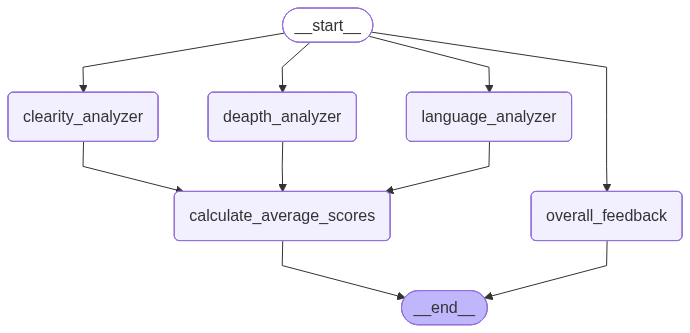

In [127]:
from IPython.display import Image

Image(workflow.get_graph().draw_mermaid_png())

In [ ]:
eassy = """
Love is one of the most powerful forces in human life. It has the ability to transform people in ways they never imagined. For a boy, love often acts as the bridge between innocence and maturity, guiding him toward growth, responsibility, and emotional depth. This journey, often subtle yet profound, marks the transformation from being a boy to becoming a man.

1. Love Teaches Responsibility

A boy often lives for himself, with little awareness of the consequences of his actions. But when he falls in love, he begins to think beyond his own needs. Suddenly, there is someone else whose happiness and well-being matter deeply. This sense of responsibility — wanting to protect, support, and provide — pushes him to make better choices, work harder, and think about the future. It is through this sense of duty that he starts stepping into the role of a man.

2. Love Brings Emotional Maturity

Love teaches a boy how to handle emotions with grace. At first, he may not understand the weight of emotions like patience, trust, or forgiveness. But love demands that he learn. Disagreements, challenges, and sacrifices teach him that relationships thrive on understanding and compromise. Over time, this emotional growth molds him into a man capable of empathy and wisdom.

3. Love Inspires Self-Discovery

Through love, a boy often learns who he truly is. The way he reacts to affection, loyalty, pain, and even heartbreak shapes his character. He begins to understand his strengths and weaknesses, his ambitions and fears. This self-awareness, born from the experiences of love, helps him evolve from a carefree youth into a man grounded in self-knowledge.

4. Love Cultivates Strength and Resilience

Love isn’t always easy; it often comes with challenges and even heartbreak. These experiences teach a boy how to stand firm, fight for what matters, and, when necessary, let go gracefully. This resilience — the ability to endure pain and still remain hopeful — is one of the most significant signs of manhood. True strength lies in loving deeply, even when it demands courage and vulnerability.

5. Love Encourages Growth and Ambition

A boy in love often finds new motivation. He strives to be better, to build a stable life, and to create a future where his loved one can thrive alongside him. This drive to grow and succeed is not just for himself anymore; it stems from the desire to share his accomplishments with someone special. Such ambition and determination are marks of maturity that define a man.

Conclusion

Love is not merely an emotion; it is a transformative force. It teaches lessons that no classroom can provide — responsibility, emotional depth, resilience, and selflessness. In the process, it shapes a boy into a man, guiding him to embrace maturity, strength, and purpose. In the end, love does more than change him; it elevates him, preparing him to not only live for himself but also to cherish, protect, and nurture others with a depth of heart that defines true manhood.
"""
inital_state = {"eassy":eassy}

final_result = workflow.invoke(inital_state)

print(final_result)

# print("--Language Feedback--")

# print(final_result.language_feedback)

# print("--Deapth Feedback--")

# print(final_result.analysis_feedback)

# print("--clearity Feedback--")

# print(final_result.clarity_feedback)

# print("--overall Feedback--")

# print(final_result.overall_feedback)

# print("--individual Scores--")

# print(final_result.individual_scores)

# print("---Average Scores---")

# print(final_result.average_scores)


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting.


--clearity Feedback--


AttributeError: 'dict' object has no attribute 'clarity_feedback'